## Radius measurement at different z-sections

Until now, the colony images were taken through ~4mm agar. The GFP signal got distorted, and very noisy images were formed. The formed noise made it very hard to automate height measurements. Even with a naked eye, it was close to impossible to find the top of the colony. In this example, Glu 04/17/2021 and Gly 04/17/2021, there is nothing in between the lens and the colony, so the GFP signal is very clear. This opens up the possibility of automated radius and height measurements!

In [1]:
%matplotlib notebook

# Dependencies

import os
import cv2
import merging_functions as mf
import numpy as np
import tracker as tr
import pandas as pd
import datetime

from matplotlib import pyplot as plt

from bs4 import BeautifulSoup

from find_circle import make_circle

In [2]:
# Go through each merged file and collect the resized image in a numpy array
def get_image_sequence(video_folder, exp_name, acq_name, t_str, zstr_ar, img_dims):
    # Initialize the img numpy array
    img_seq = np.zeros((img_dims[0], img_dims[1], len(zstr_ar)), np.uint8)
    # Go over each z-stack image
    video_path = os.path.join(video_folder, f"{exp_name}_{acq_name}", f"{exp_name}_{acq_name}.avi")

    # Video capture object
    vidcap = cv2.VideoCapture(video_path)
    for zix in range(len(zstr_ar)):
        z_str = zstr_ar[zix]
        # Collect the path of the merged files
        try:
            success, frame = vidcap.read()
            
            # Convert to grayscale
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Add to image sequence array
            img_seq[:,:,zix] = frame_gray

        except Exception as e:
            print(success)
            print(f"Error! Cannot read video from path {video_path}")
        
    return img_seq

In [6]:
exp_name = "EQ59_Glu_04172021"
# exp_folder = os.path.join("D:\\", "Tolga", f"{exp_name}")
exp_folder = os.path.join("C:", "Users", "Tolga", "Dropbox", "PriME", "ColonyProject", f"{exp_name}")
inner = True
tstr = "t0"
dim = (512,512)
ksz_um = 10 # Kernel size for filters in um

plate_csv_path = os.path.join(exp_folder, f"{exp_name}_Plates.csv")
timepoint_csv_path = os.path.join(exp_folder, f"{exp_name}_TimePoints.csv")

plate_df = pd.read_csv(plate_csv_path)
timepoint_df = pd.read_csv(timepoint_csv_path)
df = plate_df.merge(timepoint_df, on="plate_id", how="inner")

tar = [] # Timepoint in hours
tpid_rh_lst = []
height = [] # Max height: surface to top at the center
radius = [] # Max radius: center to edge at the surface

rarz = [] # for each acquisition, collect radius at each z-section
zarz = [] # each acquisition has its own z-sections. save all z values

cross_section_df = pd.DataFrame()
# Run through each acquisition
for (index,row) in df.iterrows():
#     if index == 1:
#         break
    # something is wrong with tp_id = 6 for  Glucose
    plt_id = row["plate_id"]
    tp_id = row["timepoint_id"]
    
    print(f"plate_id: {plt_id} - tp_id: {tp_id}")

#     if tp_id == 6:
#         continue
    
    acq_name = f"TileScan_Plt{plt_id}_Tp{tp_id}"
    metadata = mf.collect_metadata(exp_folder, exp_name, acq_name, inner=inner)

    hours = (metadata["start_time"]- pd.Timestamp(row["time_prepared"])).total_seconds()/3600
    tar.append(hours)
    
    # Calculate kernel size in pixels for fixed length
    xvoxel = metadata["dimensions"]["X"]["Voxel"]
    yvoxel = metadata["dimensions"]["Y"]["Voxel"]
    xnum = metadata["dimensions"]["X"]["NumberOfElements"]
    ynum = metadata["dimensions"]["Y"]["NumberOfElements"]
    w = metadata["tiles"]["xix_unique_ar"].size*xnum
    h = metadata["tiles"]["yix_unique_ar"].size*ynum

    ksz_um = 10 # Kernel size for filters in um

    ksz_px = ksz_um/xvoxel
    # Make kernel size an odd integer
    ksz_px = int(ksz_px/2)*2 + 1
    print(f"width: {w} - height: {h}")
    print(f"kernel um: {ksz_um} - kernel px: {ksz_px}")
    
    # Go through each z and collect radius 
    zsz = metadata["dimensions"]["Z"]["NumberOfElements"]
    zvoxel = -metadata["dimensions"]["Z"]["Voxel"]
    zar_um = []
    rar_um = []
    tp_id_lst = []
    
    # First, collect image sequence
    # Find the number of digits
    znum_digit = len(str(zsz-1))
    # zstr for file path
    zstr_holder = f"z%0{znum_digit}d"

    # calculate z_strar for each z_str value
    z_strar = np.zeros(zsz, dtype="<U6")
    for zix in range(zsz):
        z_strar[zix] = zstr_holder % zix


    # Read an image
    video_folder = os.path.join(exp_folder, "Videos_Full_Unmarked")

    print("\nCollecting image sequence")
    img_seq = get_image_sequence(video_folder, exp_name, acq_name, tstr, z_strar, dim)
    
    print("Calculating radius for each z-section: ")
    for zix in range(zsz):
#         print(f"{zix}/{zsz}", end="\r", flush=True)
        roi_image = img_seq[:, :, zix]
        blurred_image = cv2.GaussianBlur(roi_image, (15,15), 0).astype(np.uint8)
    #     blurred_image = roi_image
        _, thresh_image = cv2.threshold(blurred_image, 80, 255, cv2.THRESH_BINARY)

        zar_um.append(zix*zvoxel)
        tp_id_lst.append(tp_id)
        
#         # Parse the positive points into 
#         (yix,xix) = np.where(thresh_image>0)
        contours, hierarchy = cv2.findContours(np.uint8(thresh_image>0), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) > 0:
            points = np.vstack(contours).squeeze()
#             points = []
#             for ix in range(len(xix)):
#                 points.append((xix[ix], yix[ix]))
            (x,y,rad) = make_circle(points)
            rar_um.append(rad*xvoxel*w/dim[0])

        else:
            rar_um.append(0)
            
    # Calculate height
    r = np.array(rar_um)
    z = np.array(zar_um)
    idx, = np.where(r > 0)
    surf = z[np.argmax(r)]
    top = z[idx[-1]]
    h = top-surf
    
    # Calculate max radius
    
    tpid_rh_lst.append(tp_id)
    radius.append(max(r))
    height.append(h)
    rarz.append(rar_um)
    zarz.append(zar_um)
    
    data = {"timepoint_id": tp_id_lst, "z(um)": z, "z-surf(um)": z-surf, "r(um)": r}
    cross_section_df = cross_section_df.append(pd.DataFrame(data), ignore_index=True)

plate_id: 1 - tp_id: 2


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Tolga\\Dropbox\\PriME\\ColonyProject\\EQ59_Glu_04172021\\EQ59_Glu_04172021\\TileScan_Plt1_Tp2\\MetaData\\TileScan_Plt1_Tp2_Properties.xml'

<IPython.core.display.Javascript object>


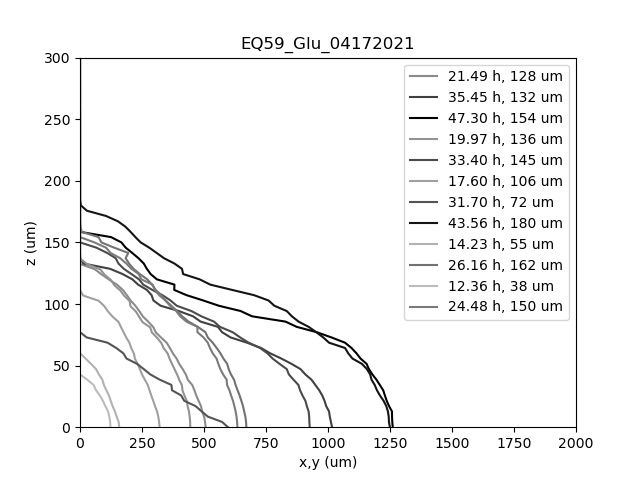

Text(0.5, 1.0, 'EQ59_Glu_04172021')

In [11]:
# Cross-sections
fig,ax = plt.subplots()
for rix in range(len(rarz)):
    # Rearrange the z values
    r = np.array(rarz[rix])
    z = np.array(zarz[rix])
    idx, = np.where(r > 0)
    surf = z[np.argmax(r)]
    top = z[idx[-1]]
    h = top-surf
    c = 1-tar[rix]/max(tar)
    ax.plot(r, z-surf, color=(c,c,c), label="%.2f h, %d um" % (tar[rix], h))
    
ax.legend()
ax.set_xlim(0, 2000)
ax.set_ylim(0,300)
ax.set_xlabel("x,y (um)")
ax.set_ylabel("z (um)")
ax.set_title(exp_name)

<IPython.core.display.Javascript object>


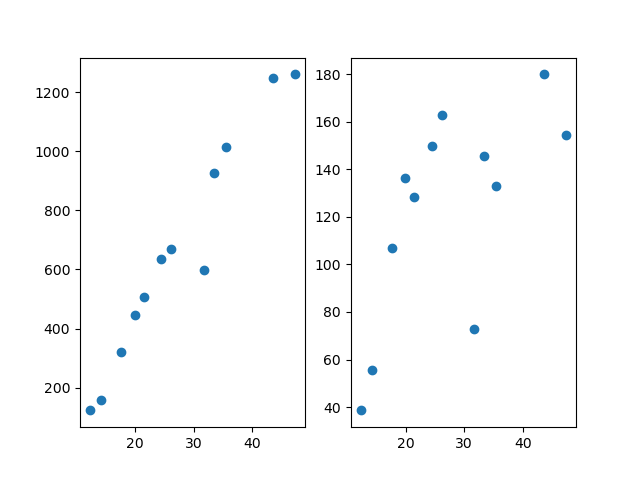

In [12]:
# height and radius
fig, axs = plt.subplots(1,2)
axs[0].plot(tar, radius, 'o')
axs[1].plot(tar, height, 'o')


In [13]:
cross_section_df.to_csv(os.path.join(exp_folder, f"{exp_name}_CrossSection.csv"), index=False)

In [14]:
cross_section_df

,timepoint_id,z(um),z-surf(um),r(um)
0,2,0.000,-94.050,0.0
1,2,4.275,-89.775,0.0
2,2,8.550,-85.500,0.0
3,2,12.825,-81.225,0.0
4,2,17.100,-76.950,0.0
...,...,...,...,...
1141,9,381.454,300.020,0.0
1142,9,385.740,304.306,0.0
1143,9,390.026,308.592,0.0
1144,9,394.312,312.878,0.0


In [15]:
radius_height_data = {"timepoint_id": tpid_rh_lst, "radius(um)": radius, "height(um)": height, "time(hr)": tar}
radius_height_df = pd.DataFrame(radius_height_data)
radius_height_df.to_csv(os.path.join(exp_folder, f"{exp_name}_RadiusHeight.csv"), index=False)

In [16]:
radius_height_df

,timepoint_df,radius(um),height(um)
0,2,506.719630,128.250
1,8,1016.317736,132.866
2,12,1261.075236,154.296
3,3,444.696758,136.544
4,7,926.361539,145.724
5,1,321.002823,106.875
6,6,596.784440,72.862
7,11,1249.595575,180.012
8,5,158.451238,55.718
9,10,670.890538,162.868
